In [22]:
import numpy as np
import time
import matplotlib.pyplot as plt
start = time.time()

In [23]:
def f1(x):
    obj=x**2
    return obj

def f2(x):
    obj=(x-2)**2
    return obj

def deltadom_a_b(a, b,R1,R2):
    if f1(a) != f1(b) and f2(a)!=f2(b):
        aux=abs(f1(a)-f1(b))/R1*abs(f2(a)-f2(b))/R2
    return aux

In [24]:
def clust(tamanho, ficheiro):
    while ficheiro.size>tamanho:
        a=np.random.choice(np.arange(ficheiro.size))
        mvalue=300
        for i in range(len(ficheiro)):
            dif = abs(ficheiro[a]-ficheiro[i])
            if dif !=0 and dif<mvalue:
                mvalue=dif
                mindex=i
        ficheiro=np.delete(ficheiro, mindex)
    return ficheiro

In [25]:
#inicialização das variáveis
Tmax=1000
Tmin=0.1
HL=50
SL=100
N=50 #número domain search 
alpha= 0.85 # deaimento da temperatura ou fator de resfriamento
temp=Tmax

#solução inicial 
z_i=10
archive =np.random.rand(SL)*z_i
x_i=np.random.choice(archive)

C=1  #fator mudança de direção
phi=0.1  #fator de redução
# variaveis contadores 
cont1=0
cont2=0
cont3=0

In [26]:
%%time
while(temp>Tmin):
    for o in range(N):
        max1=max(f1(archive))
        min1=min(f1(archive))
        max2=max(f2(archive))
        min2=min(f2(archive))
        R1=max1-min1
        R2=max2-min2
        deldom_k_j=0
        #reset dos contadores
        cont1 = 0
        cont2=0
        cont3 = 0
        #geração da nova solução
        x_j=x_i+C*phi*np.random.rand()
        #função para obter as soluções de dominancia
        k=np.empty([0],dtype=float)
        for i in range(1,archive.size):
            if f1(archive[i])<=f1(x_j) and f2(archive[i])<=f2(x_j): #neste caso o archive domina o novo ponto
                cont1=cont1+1
                k=np.append(k,archive[i-1])
            elif f1(archive[i-1])<=f1(x_j) or f2(archive[i])<=f2(x_j):
                cont3=cont3+1
            else:
                cont2=cont2+1
#####################################################################################################
#####################  caso 1 #######################################################################
        if (f1(x_i)<f1(x_j) and f2(x_i)<f2(x_j)):
            #print(Fore.RED,"A solução atual domina a solução nova")
            deltadom_i_j=deltadom_a_b(x_i, x_j, R1, R2)
            deldom_k_j=0
            for i in range(k.size):
                deldom_k_j=deldom_k_j+deltadom_a_b(k[i],x_j, R1, R2)
            deltadom_avg=(deldom_k_j+deltadom_i_j)/(k.size+1)
            prob=1/(1+np.exp(deltadom_avg*temp))
            p=np.random.rand()
            if p<prob:
                x_i=x_j  #a solução nova é atribuída ao corrente.
                C=1
                #print(Fore.BLACK, "a corrente agora é a solução nova")
            else:
                x_i=x_i
                C=-1
        ################################################################################################
        ################  caso 2 #######################################################################
        elif (f1(x_i)<f1(x_j) or f2(x_i)<f2(x_j)):
            if (k.size>=1):
                for i in range(k.size):
                    deltadom_avg=deltadom_a_b(k[i],x_j,R1,R2)/(k.size)
                prob=1/(1+np.exp(deltadom_avg*temp))
                p=np.random.rand()
                if p<prob:
                    x_i=x_j
                    C=1
                else:
                    x_i=x_i
                    C=-1
            elif (cont3>0):  #as soluções do arquivo não domina e tabém não é dominado
                #print(Fore.BLUE, "as soluções do arquivo não domina e tabém não é dominado")
                x_i=x_j
                archive=np.append(archive,x_j)
                if archive.size>SL:
                    archive=clust(HL,archive)
                #clustering algorítimo 
            else: # a solução nova domina os pontos k
                #print(Fore.BLUE, "A solução nova domina os pontos k")
                x_i=x_j
                archive=np.append(archive,x_j)
                for i in range(archive.size):
                    if f1(x_j)<f1(archive[i]) and f2(x_j)<f2(archive[i]):
                        archive=np.delete(archive, i)
                #print(Fore.GREEN, "O tamanho do arquivo", archive.size)
        ################# caso 3##########################################################################
        else:
            #print(Fore.RED, "A solução nova domína a solução atual")# caso 3 (a) as soluções de k domina o novo ponto
            if k.size>=1: 
                #### necessário melhorar essa parte --- 1 check
                aux_d=np.empty([0])
                aux_d=(abs(f1(x_j)-f1(k))/R1)*((abs(f2(x_j)-f2(k))/R2))
                menor=np.amin(aux_d)
                posi=np.argmin(aux_d)
                #for i in range(1,k.size):
                 #   aux_d=(f1(x_j)-f1(k[i])/R1)*((f2(x_j)-f2(k[i])/R2))
                      #  if aux_d<deltadom_min:
                           #     deltadom_min=aux_d
                            #    posi=i
                            #else:
                #   deltadom_min=deltadom_min
                prob=1/(1+np.exp(menor))
                #print(prob)
                if np.random.rand()<prob:
                    x_i=k[posi]
                else:
                    x_i=x_j
            elif cont3>=1 and k.size==0 and cont2 == 0:  ###############  caso 3 (b) o novo ponto não domina e nem é dominado pelo arquivo
                archive=np.append(archive, x_j)
                for i in range(archive.size):
                    if x_i == archive[i]:
                        archive=np.delete(archive, i)
                    elif archive.size>SL:
                        archive=clust(HL,archive)
                x_i=x_j   
            else: ###############   caso 3 (c) Quando 
                x_i=x_j
                archive=np.append(archive,x_j)
                #print("CAso 3 (C)")
                contador=0
                while(contador < archive.size):
                    if f1(x_j)<f1(archive[contador]) and f2(x_j)<f2(archive[contador]):
                        archive=np.delete(archive, contador)
                        contador=contador+1
                    else:
                        contador=contador+1
        #print(k.size)
    temp=temp*alpha
if archive.size>SL:
    archive=clust(HL,archive)

IndexError: index 53 is out of bounds for axis 0 with size 53

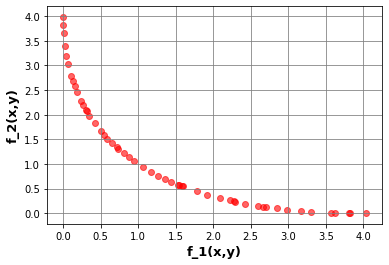

In [31]:
xg=np.linspace(-0.5, 2.5)
#plt.plot(f1(xg),f2(xg), color='b',linewidth=1)
plt.grid(b=None, color='grey', which='major', axis='both')
plt.scatter(f1(archive),f2(archive),color='r',alpha=0.6)
plt.xlabel("f_1(x,y)", fontsize=13,fontweight='bold')
plt.ylabel("f_2(x,y)",fontsize=13,fontweight='bold')
#plt.title("Pareto Front",fontsize=15,fontweight='bold')
plt.savefig("amosa-schaff.png")

In [28]:
print(archive.size)
end = time.time()
minu=np.around((end-start)/60,0)
sec=np.around((end-start)%60,0)

53


In [29]:
print(end-start)
print(minu, "min", sec, "segundos")

0.9289100170135498
0.0 min 1.0 segundos
